## Import libraries

In [ ]:
#Lung Cancer dataset(Actual Code 20230508)

In [ ]:
import h5py
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount("/content/gdrive")
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

import lightgbm as lgb

from skimage import util, exposure
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

f = h5py.File('gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/lung nodule data/all_patches.hdf5','r')
print(list(f.keys()))

ct_slices = f['ct_slices']
slice_class = f['slice_class']

ct_slices = np.array(ct_slices)
slice_class = np.array(slice_class)
print(ct_slices.shape)
print(slice_class.shape)
print(ct_slices[1].min())
#print(slice_class)
slice_class=slice_class.flatten()
print(slice_class.shape)

Mounted at /content/gdrive
['ct_slices', 'slice_class']
(6691, 64, 64)
(6691, 1)
-1024.0
(6691,)


320.0
-1000.0


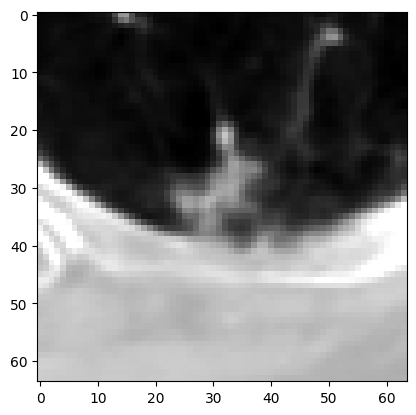

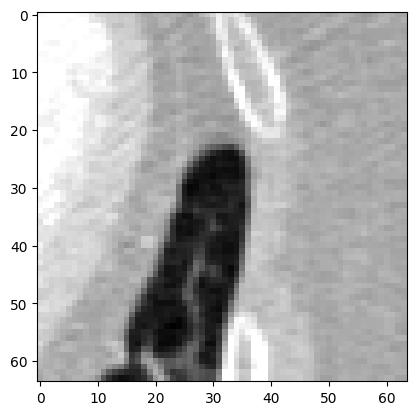

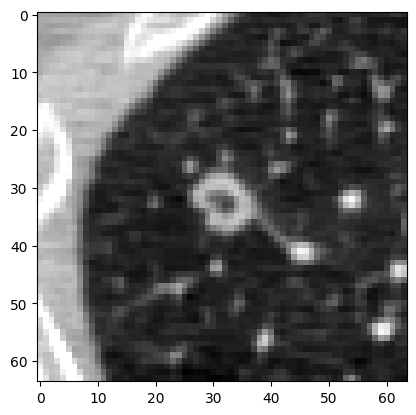

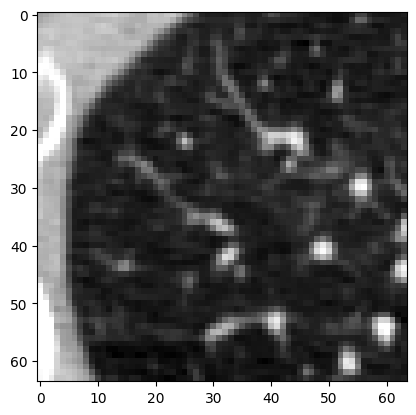

In [ ]:
import pylab
ct_slices = np.clip(ct_slices, -1000,320)
print(ct_slices.max())
print(ct_slices.min())

pylab.imshow(ct_slices[5], cmap=pylab.cm.gray)
pylab.show()
pylab.imshow(ct_slices[50], cmap=pylab.cm.gray)
pylab.show()
pylab.imshow(ct_slices[92], cmap=pylab.cm.gray)
pylab.show()
pylab.imshow(ct_slices[89], cmap=pylab.cm.gray)
pylab.show()

In [ ]:
bin_width = 32

X_scaled = exposure.rescale_intensity(ct_slices, out_range=(0, 1))
X_binned = util.img_as_ubyte(X_scaled)
X_binned = X_binned // bin_width

In [ ]:
X_scaled

array([[[0.6090909 , 0.5719697 , 0.5234848 , ..., 0.22651514,
         0.1780303 , 0.04924243],
        [0.5560606 , 0.49848485, 0.4340909 , ..., 0.10227273,
         0.11060606, 0.05075758],
        [0.48333332, 0.43030304, 0.3598485 , ..., 0.06439394,
         0.08030303, 0.05151515],
        ...,
        [0.7765151 , 0.7643939 , 0.7469697 , ..., 0.6840909 ,
         0.6871212 , 0.68636364],
        [0.7522727 , 0.74545455, 0.7507576 , ..., 0.6871212 ,
         0.68560606, 0.68863636],
        [0.74545455, 0.7522727 , 0.76969695, ..., 0.66742426,
         0.6606061 , 0.669697  ]],

       [[0.25      , 0.21742424, 0.19848485, ..., 0.0689394 ,
         0.04621212, 0.03939394],
        [0.19242424, 0.14696969, 0.1310606 , ..., 0.0530303 ,
         0.02424242, 0.03106061],
        [0.15227273, 0.11287878, 0.10530303, ..., 0.04318182,
         0.01590909, 0.01439394],
        ...,
        [0.7712121 , 0.76363635, 0.7643939 , ..., 0.6909091 ,
         0.68863636, 0.67954546],
        [0.7

In [ ]:
X_binned


array([[[4, 4, 4, ..., 1, 1, 0],
        [4, 3, 3, ..., 0, 0, 0],
        [3, 3, 2, ..., 0, 0, 0],
        ...,
        [6, 6, 5, ..., 5, 5, 5],
        [6, 5, 5, ..., 5, 5, 5],
        [5, 6, 6, ..., 5, 5, 5]],

       [[2, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [6, 6, 6, ..., 5, 5, 5],
        [5, 6, 6, ..., 5, 5, 5],
        [5, 6, 6, ..., 5, 5, 5]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [6, 6, 6, ..., 5, 5, 5],
        [6, 6, 6, ..., 5, 5, 5],
        [6, 6, 6, ..., 5, 5, 5]],

       ...,

       [[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 1],
        [0, 1, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 2, 1, 1],
        ...,
        [1, 1, 1, ..., 

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
ct_slices = ct_slices.reshape(6691,64,64)
slice_class = slice_class.reshape(6691,1)

X_train, X_test, y_train, y_test = train_test_split(X_binned, slice_class, test_size=0.33, random_state=42)

#y_train = keras.utils.to_categorical(y_train, num_classes=2)
#y_test = keras.utils.to_categorical(y_test, num_classes=2)
y_train=y_train.flatten()
y_test=y_test.flatten()

print(X_train.shape)
print(y_train.shape)

(4482, 64, 64)
(4482,)


In [ ]:

def feature_extraction(data):
    img_ds = pd.DataFrame()

    # Iterate through images in file
    for img in range(data.shape[0]):
        # Create a data frame temperory to give features
        df = pd.DataFrame()
        image = data[img,:,:]

        # Now, we add data to data frame using GLCM
        # GLCM = greycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(image, [1], [0])
        GLCM_energy = greycoprops(GLCM, "energy")[0]
        df["Energy"] = GLCM_energy
        GLCM_corr = greycoprops(GLCM, "correlation")[0]
        df["Correlation"] = GLCM_corr
        GLCM_diss = greycoprops(GLCM, "dissimilarity")[0]
        df["Dissimilarity"] = GLCM_diss
        GLCM_homgen = greycoprops(GLCM, "homogeneity")[0]
        df["Homogenity"] = GLCM_homgen
        GLCM_cont = greycoprops(GLCM, "contrast")[0]
        df["Contrast"] = GLCM_cont

        # GLCM 2
        GLCM2 = greycomatrix(image, [3], [0])
        GLCM_energy2 = greycoprops(GLCM2, "energy")[0]
        df["Energy2"] = GLCM_energy2
        GLCM_corr2 = greycoprops(GLCM2, "correlation")[0]
        df["Correlation2"] = GLCM_corr2
        GLCM_diss2 = greycoprops(GLCM2, "dissimilarity")[0]
        df["Dissimilarity2"] = GLCM_diss2
        GLCM_homgen2 = greycoprops(GLCM2, "homogeneity")[0]
        df["Homogeneity2"] = GLCM_homgen2
        GLCM_cont2 = greycoprops(GLCM2, "contrast")[0]
        df["Contrast2"] = GLCM_cont2

        # GLCM 3
        GLCM3 = greycomatrix(image, [5], [0])
        GLCM_energy = greycoprops(GLCM3, "energy")[0]
        df["Energy3"] = GLCM_energy
        GLCM_corr3 = greycoprops(GLCM3, "correlation")[0]
        df["Correlation3"] = GLCM_corr3
        GLCM_diss3 = greycoprops(GLCM3, "dissimilarity")[0]
        df["Dissimilarity3"] = GLCM_diss3
        GLCM_homgen3 = greycoprops(GLCM3, "homogeneity")[0]
        df["Homogeneity3"] = GLCM_homgen3
        GLCM_cont3 = greycoprops(GLCM3, "contrast")[0]
        df["Contrast3"] = GLCM_cont3

        # GLCM 4
        GLCM4 = greycomatrix(image, [0], [np.pi/4])
        GLCM_energy4 = greycoprops(GLCM4, "energy")[0]
        df["Energy4"] = GLCM_energy4
        GLCM_corr4 = greycoprops(GLCM4, "correlation")[0]
        df["Correlation4"] = GLCM_corr4
        GLCM_diss4 = greycoprops(GLCM4, "dissimilarity")[0]
        df["Dissimilarity4"] = GLCM_diss4
        GLCM_homgen4 = greycoprops(GLCM4, "homogeneity")[0]
        df["Homogeneity4"] = GLCM_homgen4
        GLCM_cont4 = greycoprops(GLCM4, "contrast")[0]
        df["Contrast4"] = GLCM_cont4

        # GLCM 5
        GLCM5 = greycomatrix(image, [0], [np.pi/4])
        GLCM_energy5 = greycoprops(GLCM5, "energy")[0]
        df["Energy5"] = GLCM_energy5
        GLCM_corr5 = greycoprops(GLCM5, "correlation")[0]
        df["Correlation5"] = GLCM_corr5
        GLCM_diss5 = greycoprops(GLCM5, "dissimilarity")[0]
        df["Dissimilarity5"] = GLCM_diss5
        GLCM_homgen5 = greycoprops(GLCM5, "homogeneity")[0]
        df["Homogeneity5"] = GLCM_homgen5
        GLCM_cont5 = greycoprops(GLCM5, "contrast")[0]
        df["Contrast5"] = GLCM_cont5

        # Append all features into img_ds
        img_ds = img_ds.append(df)

    return img_ds

In [ ]:
# Now, extract features from X_train
img_features = feature_extraction(X_train)
X_for_training = img_features

# Now, extract features from X_test
img_test_features = feature_extraction(X_test)
img_test_features = np.expand_dims(img_test_features, axis=0)
X_for_test = np.reshape(img_test_features, (X_test.shape[0], -1))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1

In [ ]:
X_for_training

,Energy,Correlation,Dissimilarity,Homogenity,Contrast,Energy2,Correlation2,Dissimilarity2,Homogeneity2,Contrast2,...,Energy4,Correlation4,Dissimilarity4,Homogeneity4,Contrast4,Energy5,Correlation5,Dissimilarity5,Homogeneity5,Contrast5
0,0.507238,0.913691,0.258929,0.874603,0.299603,0.431372,0.665844,0.590932,0.747868,1.077613,...,0.615644,1.0,0.0,1.0,0.0,0.615644,1.0,0.0,1.0,0.0
0,0.265052,0.933602,0.550347,0.737058,0.673363,0.240532,0.846135,0.859631,0.635319,1.558914,...,0.416280,1.0,0.0,1.0,0.0,0.416280,1.0,0.0,1.0,0.0
0,0.700319,0.894623,0.249256,0.887617,0.375744,0.628925,0.491236,0.608863,0.782749,1.698514,...,0.763610,1.0,0.0,1.0,0.0,0.763610,1.0,0.0,1.0,0.0
0,0.765032,0.945731,0.175347,0.923326,0.288938,0.727010,0.700401,0.459529,0.847872,1.430840,...,0.798389,1.0,0.0,1.0,0.0,0.798389,1.0,0.0,1.0,0.0
0,0.371636,0.974356,0.238591,0.883879,0.270337,0.311012,0.887404,0.610656,0.746960,1.183402,...,0.442303,1.0,0.0,1.0,0.0,0.442303,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.334872,0.937185,0.452629,0.793174,0.654514,0.291402,0.833813,0.815574,0.668833,1.719775,...,0.465811,1.0,0.0,1.0,0.0,0.465811,1.0,0.0,1.0,0.0
0,0.698229,0.907889,0.164435,0.918180,0.168403,0.630431,0.657295,0.415471,0.813856,0.633197,...,0.758319,1.0,0.0,1.0,0.0,0.758319,1.0,0.0,1.0,0.0
0,0.360545,0.951905,0.420139,0.808689,0.609127,0.291286,0.772482,1.018955,0.646861,2.908299,...,0.473595,1.0,0.0,1.0,0.0,0.473595,1.0,0.0,1.0,0.0
0,0.359856,0.967769,0.348710,0.831101,0.403274,0.313071,0.882480,0.735656,0.698100,1.469262,...,0.462334,1.0,0.0,1.0,0.0,0.462334,1.0,0.0,1.0,0.0


In [ ]:
X_for_test

array([[0.50909836, 0.916833  , 0.49330357, ..., 0.        , 1.        ,
        0.        ],
       [0.50823009, 0.97027054, 0.21875   , ..., 0.        , 1.        ,
        0.        ],
       [0.42624153, 0.98519817, 0.15997024, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.47957985, 0.96755528, 0.17981151, ..., 0.        , 1.        ,
        0.        ],
       [0.44915599, 0.97766851, 0.26388889, ..., 0.        , 1.        ,
        0.        ],
       [0.33279294, 0.94155114, 0.51463294, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
!pip install metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.7/841.7 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for metrics: filename=metrics-0.3.3-py2.py3-none-any.whl size=17807 sha256=e2bb5a8cd691a9a4a6ed6c3a158be7d007e0e20083ce6029d600e59a1a7df6ea
  Stored in directory: /root/.cache/pip/wheels/29/7a/e7/1175d9ff10607b8f02aa37c32392cb28cdda0aea8fcc2b514b
  Created wheel for pathspec: filename=pathspec-0.5.5-py3-none-any.whl size=24235 sha256=80d4a2f115701aeb2cdf9f7c061ceca622d4dbb0e110ecf7bd1f2f1d6038a569
  Stored in directory: /root/.cache/pip/wheels/28/d4/11/01ccd690e97b06874998aa554a8b2610c361900d2a7e038300
Successfully built metrics pathspec
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.14.0
    Uninstalling Pygments-2.14.0:
      Successfully uninstalled Pygments-2.14.0
ERROR: pip's de

In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.8 MB/s eta 0:00:00
time: 525 µs (started: 2023-05-08 03:16:26 +00:00)


In [ ]:
from lightgbm import LGBMClassifier
dtrain = lgb.Dataset(X_for_training, label = y_train)

# Set the lgbm parameters
# Note: here we are a binary classification problem, so 'objective' should be 'binary'
# while if we have multiple class, 'objective' would be 'multiclass'
lgbm_parameters = {"learning_rate":0.033,
                   "task":"train",
                   "boosting_type":"gbdt",
                   "objective":"binary",
                   "metric":'binary_logloss',
                   "num_leaves":20, #63
                   "min_data_in_leaf":1, #1
                   #"feature_fraction":1.0,
                   "bagging_freq":50,
                   "bagging_fraction":0.8,
                   "max_depth":5,
                   "num_class":1
                  }


time: 1.66 ms (started: 2023-05-08 03:29:19 +00:00)


In [ ]:
lgbm_model = lgb.train(lgbm_parameters, dtrain, 100000)
#lgbm_model=LGBMClassifier(**lgbm_parameters,n_estimators=10000)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
import time
#t0=time.process_time()
#lgbm_model.fit(X_for_training,y_train)
#print("Training time:",time.process_time())
#y_pred_proba=lgbm_model.predict_proba(X_for_test)[::,1]
prediction = lgbm_model.predict(X_for_test)

time: 23.5 s (started: 2023-05-05 17:08:10 +00:00)


In [ ]:
acc = accuracy_score(prediction.round(), y_test)
print("Accuracy = {}".format(acc))

Accuracy = 0.8162064282480761
time: 6.43 ms (started: 2023-05-05 17:08:34 +00:00)


In [ ]:
from sklearn import metrics

fpr_lg, tpr_lg, _=metrics.roc_curve(y_test,prediction)
auc_lg=metrics.roc_auc_score(y_test,prediction)
# print("ROC_AUC score",auc)
# plt.plot(fpr,tpr,label="AUC"+str(auc),color='red')
# plt.plot([0,1],[0,1],linestyle='--')
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc=4)
# plt.show()

time: 14.9 ms (started: 2023-05-05 17:30:37 +00:00)


In [ ]:
print(classification_report(y_test, prediction.round()))

              precision    recall  f1-score   support

         0.0       0.82      0.89      0.86      1358
         1.0       0.80      0.69      0.74       851

    accuracy                           0.82      2209
   macro avg       0.81      0.79      0.80      2209
weighted avg       0.82      0.82      0.81      2209

time: 32.6 ms (started: 2023-05-05 17:10:22 +00:00)


In [ ]:
RF_model = RandomForestClassifier(n_estimators=10000, random_state=42,max_depth = 5,bootstrap = True)
#t1=time.process_time()
RF_model.fit(X_for_training, y_train)
#print("Training time:",time.process_time()-t1)
print("Fitting the RF model")

Fitting the RF model
time: 1min 46s (started: 2023-05-05 17:44:20 +00:00)


In [ ]:
# Predict the model
y_proba_rf=RF_model.predict_proba(X_for_test)[::,1]
y_pred = RF_model.predict(X_for_test)

# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy = {}".format(accuracy))

print(classification_report(y_test, y_pred.round()))



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy = 0.6387505658669081
              precision    recall  f1-score   support

         0.0       0.63      0.99      0.77      1358
         1.0       0.81      0.08      0.15       851

    accuracy                           0.64      2209
   macro avg       0.72      0.53      0.46      2209
weighted avg       0.70      0.64      0.53      2209

time: 5.85 s (started: 2023-05-05 17:46:16 +00:00)


ROC_AUC score 0.6902076565904447


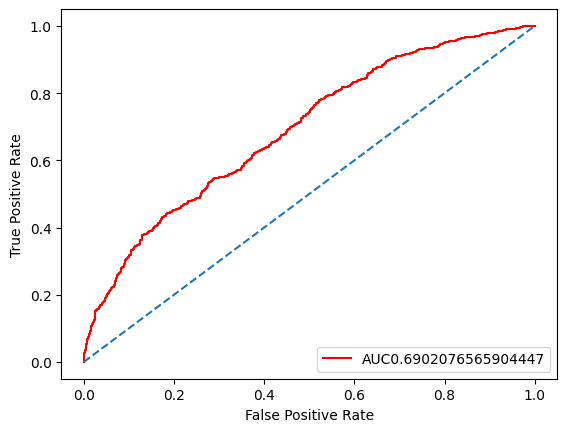

time: 684 ms (started: 2023-05-05 17:49:51 +00:00)


In [ ]:
fpr_rf, tpr_rf, _=metrics.roc_curve(y_test,y_proba_rf)
auc_rf=metrics.roc_auc_score(y_test,y_proba_rf)
print("ROC_AUC score",auc_rf)
plt.plot(fpr_rf,tpr_rf,label="AUC"+str(auc_rf),color='red')
plt.plot([0,1],[0,1],linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
C = 4.0
#t3=time.process_time()
SVM_model = svm.SVC(kernel="rbf", C=C, degree=5).fit(X_for_training, y_train)
#print("Training time:",time.process_time())
print("Training SVM model")

Training SVM model
time: 1.64 s (started: 2023-05-07 16:23:50 +00:00)


In [ ]:
# Predict the model
SVM_model.fit(X_for_training,y_train)
#y_proba_svm=SVM_model.predict_proba(X_for_test)[::,1]
y_pred_svm = SVM_model.predict(X_for_test)

# Check the accuracy
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy = {}".format(accuracy))

print(classification_report(y_test, y_pred_svm.round()))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy = 0.6165685830692621
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76      1358
         1.0       1.00      0.00      0.01       851

    accuracy                           0.62      2209
   macro avg       0.81      0.50      0.39      2209
weighted avg       0.76      0.62      0.47      2209

time: 2.34 s (started: 2023-05-07 16:23:56 +00:00)


ROC_AUC score 0.5023501762632198


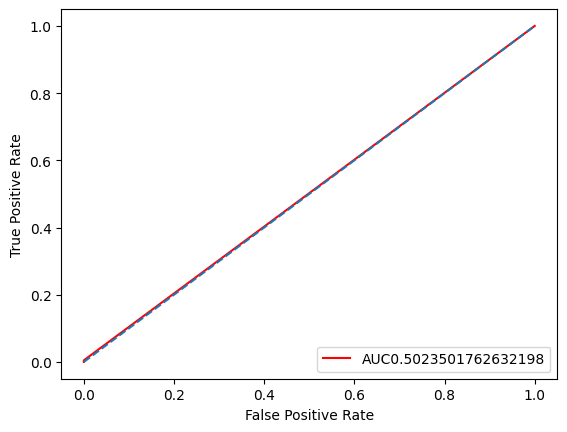

time: 411 ms (started: 2023-05-07 16:23:36 +00:00)


In [ ]:
from sklearn import metrics

fpr_svm, tpr_svm, _=metrics.roc_curve(y_test,y_pred_svm)
auc_svm=metrics.roc_auc_score(y_test,y_pred_svm)
print("ROC_AUC score",auc_svm)
plt.plot(fpr_svm,tpr_svm,label="AUC"+str(auc_svm),color='red')
plt.plot([0,1],[0,1],linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

ROC_AUC score of LGBM 0.871552829643372
ROC_AUC score of Random Forest 0.6902076565904447
ROC_AUC score of SVM 0.5023501762632198


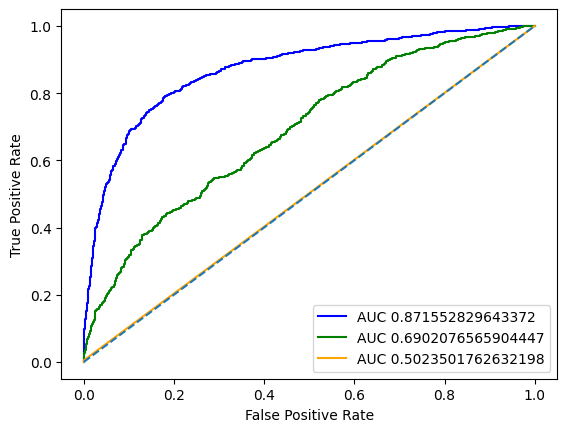

time: 296 ms (started: 2023-05-05 17:50:05 +00:00)


In [ ]:
print("ROC_AUC score of LGBM",auc_lg)
print("ROC_AUC score of Random Forest",auc_rf)
print("ROC_AUC score of SVM",auc_svm)
plt.plot(fpr_lg,tpr_lg,label="AUC "+str(auc_lg),color='blue')
plt.plot(fpr_rf,tpr_rf,label="AUC "+str(auc_rf),color='green')
plt.plot(fpr_svm,tpr_svm,label="AUC "+str(auc_svm),color='orange')
plt.plot([0,1],[0,1],linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()